## library

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import string
import joblib
# For text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

# For vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# For model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Machine Learning Models
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC


# For combining sparse matrices
from scipy.sparse import hstack, csr_matrix

# Set random seed
RANDOM_STATE = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


# data&features process

In [3]:
# Load the data
data = pd.read_csv("/content/drive/My Drive/cs506_mid/train.csv")

# Drop rows where 'Score' is missing
data = data.dropna(subset=['Score'])
#data_sampled = data.sample(n=15000, random_state=RANDOM_STATE).reset_index(drop=True)

data_sampled=data
# Preprocessing function for text data
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove whitespace
    text = text.strip()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(word) for word in tokens]
    # Re-join tokens
    text = ' '.join(tokens)
    return text
data_sampled['Summary'] = data_sampled['Summary'].fillna('')
data_sampled['Text'] = data_sampled['Text'].fillna('')
data_sampled['HelpfulnessNumerator'] = data_sampled['HelpfulnessNumerator'].fillna(0)
data_sampled['HelpfulnessDenominator'] = data_sampled['HelpfulnessDenominator'].fillna(1)
data_sampled['Processed_Summary'] = data_sampled['Summary'].apply(preprocess_text)
data_sampled['Processed_Text'] = data_sampled['Text'].apply(preprocess_text)


tfidf_vectorizer_summary = TfidfVectorizer(max_features=2000, ngram_range=(1,2))
tfidf_vectorizer_text = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

tfidf_matrix_summary = tfidf_vectorizer_summary.fit_transform(data_sampled['Processed_Summary'])
tfidf_matrix_text = tfidf_vectorizer_text.fit_transform(data_sampled['Processed_Text'])


#joblib.dump(tfidf_vectorizer_summary, 'tfidf_vectorizer_summary.pkl')
#joblib.dump(tfidf_vectorizer_text, 'tfidf_vectorizer_text.pkl')

#tfidf_vectorizer_summary = joblib.load('tfidf_vectorizer_summary.pkl')
#tfidf_vectorizer_text = joblib.load('tfidf_vectorizer_text.pkl')
#tfidf_matrix_summary = tfidf_vectorizer_summary.transform(data_sampled['Processed_Summary'])
#tfidf_matrix_text = tfidf_vectorizer_text.transform(data_sampled['Processed_Text'])


def calculate_helpfulness_ratio(row):
    num = row['HelpfulnessNumerator']
    den = row['HelpfulnessDenominator']
    if den == 0:
        return 0
    else:
        return num / den

data_sampled['HelpfulnessRatio'] = data_sampled.apply(calculate_helpfulness_ratio, axis=1)

features = ['Processed_Summary','Processed_Text','HelpfulnessNumerator','HelpfulnessDenominator','HelpfulnessRatio']
X=data_sampled[features]
numerical_features = data_sampled[['HelpfulnessNumerator', 'HelpfulnessDenominator', 'HelpfulnessRatio']].fillna(0)

# Convert numerical features to sparse matrix
numerical_features_sparse = csr_matrix(numerical_features.values)

# Combine numerical features and vectorized 'Summary' and 'Text' features
X = hstack([numerical_features_sparse, tfidf_matrix_summary, tfidf_matrix_text])
y=data_sampled['Score'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

# model training

In [6]:
X_train = X_train.copy()
X_test = X_test.copy()
y_train = y_train.copy()
y_test = y_test.copy()
# Base estimators
estimators = [
    ('lr', LogisticRegression(max_iter=10000, random_state=RANDOM_STATE)),
    ('linear_svc', LinearSVC(random_state=RANDOM_STATE)),
]

# Final estimator
final_estimator = GradientBoostingClassifier(random_state=RANDOM_STATE)

# Initialize StackingClassifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1
)
stacking_clf.fit(X_train, y_train)

In [ ]:
#joblib.dump(stacking_clf, '/content/drive/My Drive/cs506_mid/trained_model.pkl')

In [16]:
#stacking_clf = joblib.load('/content/drive/My Drive/cs506_mid/trained_model_biggest.pkl')

# model evalutaion

In [17]:
trained_model=stacking_clf
y_pred=trained_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6701742692775079
[4 2 5 ... 5 3 5]
Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.69      0.66     18238
           2       0.46      0.31      0.37     17936
           3       0.50      0.40      0.45     35216
           4       0.51      0.37      0.43     67046
           5       0.75      0.90      0.82    158633

    accuracy                           0.67    297069
   macro avg       0.57      0.53      0.55    297069
weighted avg       0.64      0.67      0.65    297069



Accuracy on testing set =  0.6701742692775079


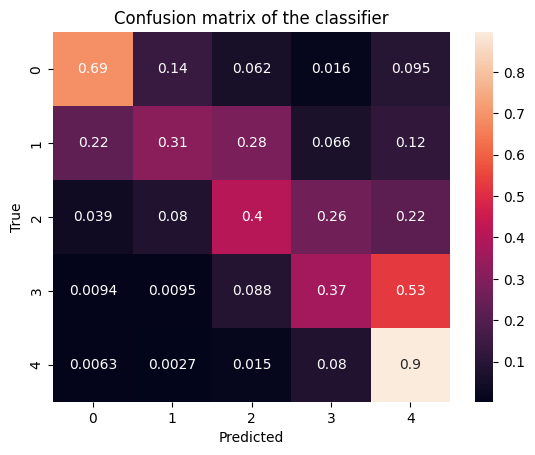

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
print("Accuracy on testing set = ", accuracy_score(y_test, y_pred))

# Plot a confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# final submission file

In [12]:
data = pd.read_csv("/content/drive/My Drive/cs506_mid/train.csv")

# Identify rows where 'Score' is NaN and reset index
nan_score_data = data[data['Score'].isna()].copy().reset_index(drop=True)

# Check if there are any rows with NaN 'Score'
if nan_score_data.empty:
    print("There are no rows with NaN 'Score' in the dataset.")
else:
    print(f"Number of rows with NaN 'Score': {len(nan_score_data)}")

    # Handle missing values in 'Summary' and 'Text'
    nan_score_data['Summary'] = nan_score_data['Summary'].fillna('')
    nan_score_data['Text'] = nan_score_data['Text'].fillna('')
    nan_score_data['HelpfulnessNumerator'] = nan_score_data['HelpfulnessNumerator'].fillna(0)
    nan_score_data['HelpfulnessDenominator'] = nan_score_data['HelpfulnessDenominator'].fillna(1)

    # Apply preprocessing separately to 'Summary' and 'Text'
    nan_score_data['Processed_Summary'] = nan_score_data['Summary'].apply(preprocess_text)
    nan_score_data['Processed_Text'] = nan_score_data['Text'].apply(preprocess_text)

    # Feature Engineering: Calculate 'HelpfulnessRatio'
    nan_score_data['HelpfulnessRatio'] = nan_score_data.apply(calculate_helpfulness_ratio, axis=1)


    #tfidf_vectorizer_summary = joblib.load('tfidf_vectorizer_summary.pkl')
    #tfidf_vectorizer_text = joblib.load('tfidf_vectorizer_text.pkl')

    # Transform 'Processed_Summary' and 'Processed_Text'
    tfidf_matrix_summary = tfidf_vectorizer_summary.transform(nan_score_data['Processed_Summary'])
    tfidf_matrix_text = tfidf_vectorizer_text.transform(nan_score_data['Processed_Text'])

    # Prepare numerical features
    numerical_features = nan_score_data[['HelpfulnessNumerator', 'HelpfulnessDenominator', 'HelpfulnessRatio']].fillna(0)
    numerical_features_sparse = csr_matrix(numerical_features.values)

    # Combine numerical features and vectorized 'Summary' and 'Text' features
    X_new = hstack([numerical_features_sparse, tfidf_matrix_summary, tfidf_matrix_text])



Number of rows with NaN 'Score': 212192


In [13]:

X_new = X_new.copy()

predictions = trained_model.predict(X_new)

results_df = pd.DataFrame({
    'Id': nan_score_data['Id'].values,
    'Score': predictions
})

results_df.to_csv('submission.csv', index=False)

print("Predicted scores have been saved to 'submission.csv'.")


Predicted scores have been saved to 'submission.csv'.
